## Genomic Data Science Specialization
Johns Hopkins University
# Course 3 : Algorithms for DNA Sequencing
Module 1 :DNA sequencing, strings and matching
## Practical: Working with sequencing reads

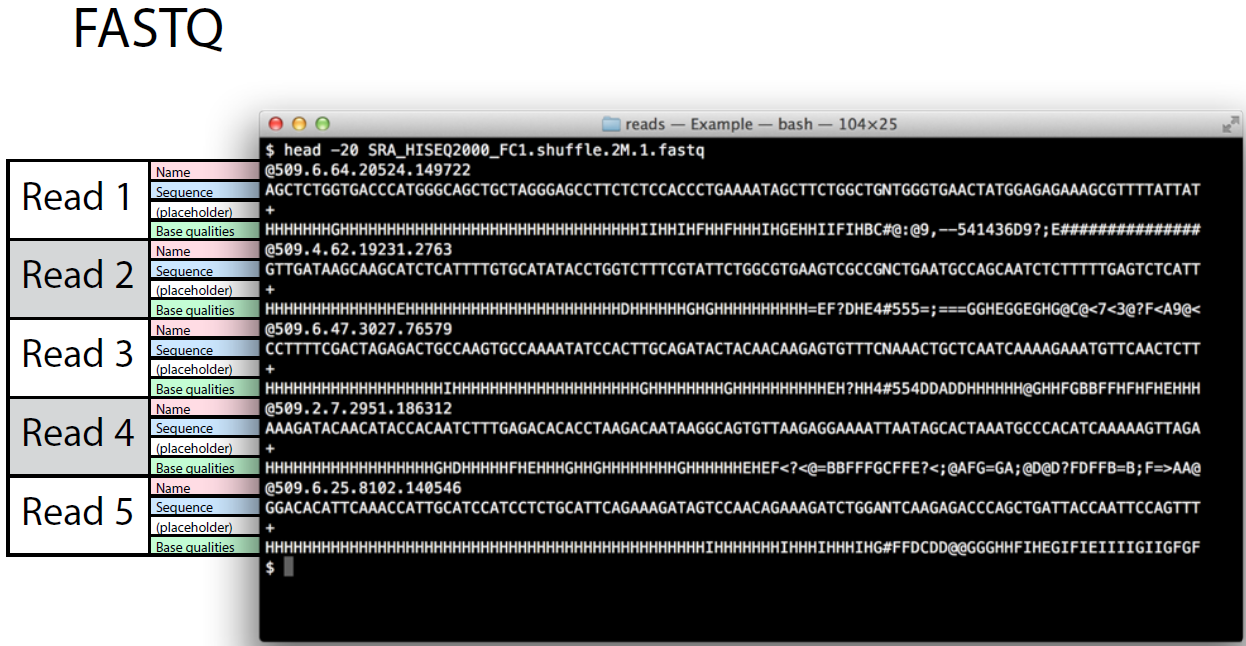

Image from

https://github.com/BenLangmead/ads1-slides/blob/master/0070_dnaseq__understanding_reads.pdf

The file in question comprises sequencing reads derived from a genuine human subject.

The data presented here are actual human sequencing reads.

In [1]:
!wget http://d28rh4a8wq0iu5.cloudfront.net/ads1/data/SRR835775_1.first1000.fastq

--2024-10-10 22:12:51--  http://d28rh4a8wq0iu5.cloudfront.net/ads1/data/SRR835775_1.first1000.fastq
Resolving d28rh4a8wq0iu5.cloudfront.net (d28rh4a8wq0iu5.cloudfront.net)... 3.163.78.34, 3.163.78.194, 3.163.78.78, ...
Connecting to d28rh4a8wq0iu5.cloudfront.net (d28rh4a8wq0iu5.cloudfront.net)|3.163.78.34|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 224786 (220K) [application/octet-stream]
Saving to: ‘SRR835775_1.first1000.fastq’

SRR835775_1.first10 100%[===================>] 219.52K  --.-KB/s    in 0.07s   

2024-10-10 22:12:52 (2.88 MB/s) - ‘SRR835775_1.first1000.fastq’ saved [224786/224786]



In [2]:
def readFastq(filename):
    sequences = []
    qualities = []
    with open(filename) as fh:
        while True:
            fh.readline() # skip name line
            seq = fh.readline().rstrip() # read base sequence
            fh.readline() # skip placeholder line
            qual = fh.readline().rstrip() #base quality line
            if len(seq) == 0:
                break
            sequences.append(seq)
            qualities.append(qual)
    return sequences, qualities
seqs, quals = readFastq('SRR835775_1.first1000.fastq')

Base quality is ASCII-encoded version of $Q = -10 log_{10} p$.

Usual ASCII encoding is “Phred+33”: take Q, rounded to integer, add 33, convert to character

In [3]:
def phred33ToQ(qual):
    return ord(qual) - 33

In [11]:
phred33ToQ('#')

2

It should be noted that a low quality score indicates a lack of confidence in the accuracy and reliability of the value in question.

The probability of this being the correct conclusion is low. In this instance, it can be posited that a quality score of two correlates with a probability of approximately 30%, or perhaps even 32%, of erroneous classification.

It can be observed that the majority of these strings of hashtags occur in proximity to the conclusion of the reads.

In [10]:
phred33ToQ('J')

41

 J is a score of 41, so that's very high. That's a very high confidence in our sent value.

It can be reasonably deduced that the highest quality score that can be observed is, in fact, 41, which was previously evidenced.

 To err on the side of caution, I propose increasing the score to 50, which should provide additional leeway at the conclusion.

In [4]:
def createHist(qualityStrings):
    # Create a histogram of quality scores
    hist = [0]*50
    for read in qualityStrings:
        for phred in read:
            q = phred33ToQ(phred)
            hist[q] += 1
    return hist
h = createHist(quals)
print(h)

[0, 0, 6178, 0, 0, 54, 108, 574, 345, 83, 193, 124, 79, 165, 49, 236, 184, 327, 514, 238, 531, 254, 313, 798, 992, 888, 1396, 1488, 993, 1752, 3387, 4487, 3248, 5476, 8375, 11814, 4243, 7827, 6579, 8179, 9349, 8180, 0, 0, 0, 0, 0, 0, 0, 0]


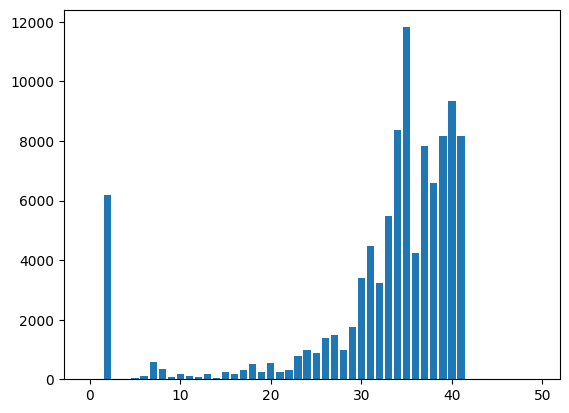

In [6]:
# Plot the histogram
%matplotlib inline
import matplotlib.pyplot as plt
plt.bar(range(len(h)), h)
plt.show()

It can be observed that there is a notable increase in the quantity of low-quality values, which subsequently declines to an extremely low level. Subsequently, there is a gradual increase, resulting in a considerable number of high-quality values.

It seems reasonable to posit that the quality value of two represents a cluster where the base caller was located.

It is not possible to determine the base with any degree of certainty. For instance, if the cluster in question were to comprise an equal mix of colours, the probability of an incorrect call would be high. This would result in a Q value of approximately 0.5, which corresponds to a low confidence level. This would suggest that the base value is likely to be around 2.

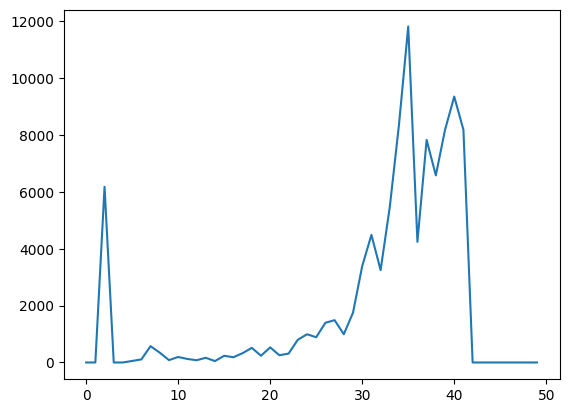

In [5]:
# Plot the line plot
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(range(len(h)), h)
plt.show()

## Practical: Analyzing reads by position
1.05_AnalyzingReadsByPosition

The GC content, that is to say, the proportion of the genome that contains G's or C's, is a variable that differs between species. Consequently, the GC content of different species varies.

In this instance, however, GC is employed merely as a means of discerning whether the proportion of different bases is undergoing alteration as the sequence progresses. It is anticipated that there will be minimal change.

It is expected that the distribution will remain relatively uniform. However, in the event of an anomalous sequencing cycle, a markedly disparate ratio of Gs and Cs relative to the other bases may be observed.

Therefore, it is necessary to plot this for the entire read in order to ascertain whether any aberrant behaviour is occurring.

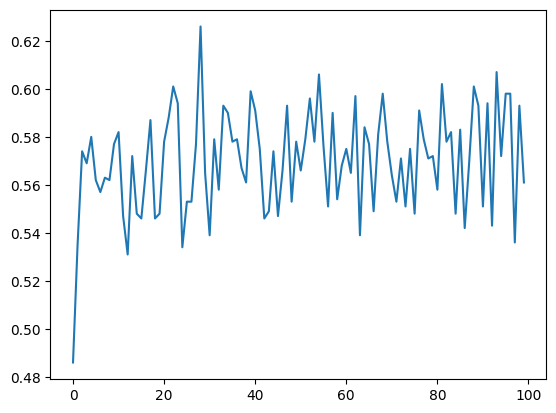

In [7]:
def findGCByPos(reads):
    ''' Find the GC ratio at each position in the read '''
    # Keep track of the number of G/C bases and the total number of bases at each position
    gc = [0] * 100
    totals = [0] * 100
    for read in reads:
        for i in range(len(read)):
            if read[i] == 'C' or read[i] == 'G':
                gc[i] += 1
            totals[i] += 1
    # Divide G/C counts by total counts to get the average at each position
    for i in range(len(gc)):
        if totals[i] > 0:
            gc[i] /= float(totals[i])
    return gc

gc = findGCByPos(seqs)
plt.plot(range(len(gc)), gc)
plt.show()

There is a considerable degree of random fluctuation, which is likely attributable to noise.

The value is consistently higher than 0.5. This is due to the fact that the human genome, which is the subject of our investigation, has a GC content that is greater than 0.5 on average.

In [8]:
import collections
count = collections.Counter()
for seq in seqs:
    count.update(seq)
count

Counter({'T': 21836, 'A': 21132, 'C': 28272, 'G': 28742, 'N': 18})

the G and C both occur at least 28,000 times, T and A only occur between 21 and 22,000 times.

\begin{align}
        GC content = \frac{G + C}{(B + A)+(G+C)}
\end{align}

So GC content is above 0.57 in this organism.

In [9]:
# Calculate GC content
total_bases = count['A'] + count['T'] + count['G'] + count['C']
gc_content = (count['G'] + count['C']) / total_bases

# Display GC content
print("GC content:", gc_content)

GC content: 0.5702426436758616
